[View in Colaboratory](https://colab.research.google.com/github/jimmyjamesarnold/10k_statistical_inferences/blob/master/10k_game_stats.ipynb)

10000 Dice Game in Python - when should you 'lock in' your score?

In [0]:
# 10000 in Python (for stats)
# single game, threshold = 200
# dice df generator 

# dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import chain, combinations

First, I need to define some functions which to use in the game simulation. 

Namely, I need a dice generator and methods to look for scoring combinations.

In [0]:
def rollDice(n) :
  """ takes input n # dice to roll, returns pd.df"""
  rollList = pd.DataFrame([[n+1,np.random.randint(1, 6)] for n in range(n)])
  rollList.columns = ['die','face']
  return rollList

def searchOnes(df):
  """pass in df from diceRoll, evaluates, saves scores and dice indices"""
  matched = len(df[df.face == 1].face)
  dice = df[df.face == 1].index.values
  if matched == 3: 
      options.append([1000, dice])
  elif matched > 3: 
      options.append([1000 * (2 ** (matched - 3)), dice])

def nOfaKind(df): 
  """pass in df from diceRoll, evaluates, saves scores and dice indices"""
  for i in range(2,7): 
      matched = len(df[df.face == i].face)
      dice = df[df.face == i].index.values         
      if matched == 3: 
          options.append([i*100, dice])
      elif matched > 3: 
          options.append([(i*100) * (2 ** (matched - 3)), dice])

def straight(df):# looks for straight
  """ looks for straight """
  if df.face.nunique() == 6:
      options.append([1000, df.index.values])

# Looks for 3 Pairs
def threePairs(df):
  """ Counts matched pairs in set, looks for 3 pairs of 2"""
  if list(Counter([(i,j) for i in df.die for j in df.face if i == j]).values()).count(2) == 3: # test for 3 sets of 2 in the list of counts of frequency of pairs
      options.append([1000, df.index.values])            

def comboSearch(df):
  """ search for scoring combos in set """
  searchOnes(df)
  nOfaKind(df)
  straight(df)
  threePairs(df)
        

Now I'm going to iterate through the simulator, varying the points threshold. I'll collect data on how many turns it takes to reach 10000.

In [0]:
threshold = list(range(100,1001,100))
allGameLengths = []
allHighScores = []
allGameRates = []
for pts in threshold:
  print(str('threshold: '),pts) # option to see if code is going
  scoreKeeper = [] # Saves top scores for stats
  gameRates = [] # Saves scoring history - I want to plot later.
  gameLengths = [] # Store time to 10000, ### need to make a conditional turn counter
  for i in range(50): # Run 50 simulations
    gameScore = [0] # this games' score
    turnsTo10k = 0 # turn counter
    for rounds in range(50): #run the game for 50 rounds, see what scores are generated
      if gameScore[-1] <= 10000:
        turnsTo10k += 1
      score = [0] #this round's score
      n = 6 # initialize n dice (6)
      while n > 0:
          options = [] # initialize options for storing combos, inside while so it's always fresh
          df = rollDice(n) #df of dice and faces
          comboSearch(df) 
          dfOpt = pd.DataFrame(options, columns = ['points', 'dice'])
          if sum(dfOpt.points) > 0 : # check for combos
              dfOpt = dfOpt[dfOpt.points == max(dfOpt.points)].reset_index() # subset for max points
              score = sum(score + dfOpt.points) # record score from sets
              df = df.drop(dfOpt.dice[0]) # drop scored dice
          else: score = 0 
          del options[:] # delete options
          dfOpt = pd.DataFrame(columns=dfOpt.columns) # clears dfOpt
          if len(df.index.values) > 0: # checks remaining dice for 1s and 5s
              extra = sum([100*len(df[df.face == 1].face)] + [50*len(df[df.face == 5].face)]) # count up 100s and 50s
              score = score + extra # add extra points
              df = df.drop(df[df.face == 1].index.values)
              df = df.drop(df[df.face == 5].index.values)     # drops remaining 1s and 5s
          if score == 0: # You rolled nothing
              gameScore.append(gameScore[-1])
              n = 0 # ends turn
          elif score >= pts and gameScore[-1] >= 1000: # Hit "threshold", lock in 
              gameScore.append(gameScore[-1] + score)
              n = 0 # ends turn
          elif score >= 1000: #You're on the board
              gameScore.append(gameScore[-1] + score)
              n = 0 # ends turn
          else: # threshold not hit, re-roll dice
              if len(df.index.values) > 0:
                n = len(df.index.values) # re-roll remaining dice.
              else: n = 6 # All dice were used, but threshold not hit, roll 6 new dice
    print(str('round: '),i,str(' final score: '),gameScore[-1]) # option to see if code is going
    scoreKeeper.append(gameScore[-1]) # save highest score
    gameRates.append(gameScore) # save scoring pattern
    gameLengths.append(turnsTo10k) # save turns to 10k
  allHighScores.append(scoreKeeper)
  allGameLengths.append(gameLengths)
  allGameRates.append(gameRates)

Now that data is generated, I can run some basic descriptive stats and test hypotheses. To answer my initial question, I need to assess the number of turns needed to reach 10000 pts. This was collected as a list of lists in allGameLengths (a list of game lengths for all threshold conditions).

This will require a little data wrangling.

In [208]:
# First, convert results to df, separate for each
df_gL = pd.DataFrame(allGameLengths, index=threshold).transpose()
df_gL.describe()

,100,200,300,400,500,600,700,800,900,1000
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,22.920000,22.540000,23.180000,23.180000,22.820000,26.460000,26.200000,28.640000,30.620000,25.120000
std,3.773376,4.790339,5.189039,5.117756,5.947697,7.254021,6.889803,8.537456,8.068305,6.454361
min,10.000000,12.000000,13.000000,13.000000,13.000000,14.000000,14.000000,7.000000,10.000000,14.000000
25%,21.000000,19.000000,20.000000,19.000000,19.000000,22.000000,22.250000,25.000000,24.000000,21.000000
50%,23.000000,22.000000,22.500000,23.500000,22.000000,25.500000,26.500000,28.000000,30.500000,24.500000
75%,25.000000,25.000000,26.000000,26.750000,25.000000,30.500000,30.500000,34.000000,36.000000,29.000000
max,31.000000,39.000000,37.000000,33.000000,42.000000,46.000000,49.000000,50.000000,49.000000,42.000000


Based on the summary stats from 50 simulations, results suggest that going low may be the best strategy for getting to 10000 first. 

The two stats that I find telling are the average (mean) and standard deviation (std). 
For the mean, 200 had the lowest mean at 22.5 turns, while 800 had the highest mean at 28.6, with a big shift up moving from from 500->600.

Standard deviation is also important to consider. Again, the low numbers were more consistent. 100 had the lowest stdev, at 3.8, while 800 had the highest at 8.53. Clearly 800 is a bad threshold, which is likely a product of the scoring system. 

To help visualize this data, we'll use a boxplot separated by thresholds. 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


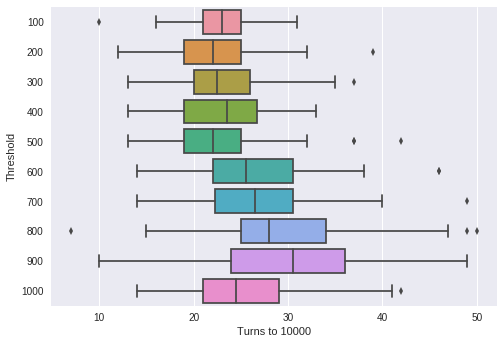

In [133]:
# Wrangle and convert length, boxplot
df_gM = pd.melt(df_gL,var_name='Threshold',value_name='Turns to 10000')
ax = sns.boxplot(y='Threshold',x='Turns to 10000',data=df_gM,orient="h")

The boxplot shows that thresholds above 500, on average, take longer to reach 10000.

What's interesting to me is that once you're on the board, locking in at 100 is just as likely to get you to 10000 as holding out for 500. 

Additionally, we can look at the ECDF of each threshold to get an idea of the relative probability of success at any given turn.

In [0]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

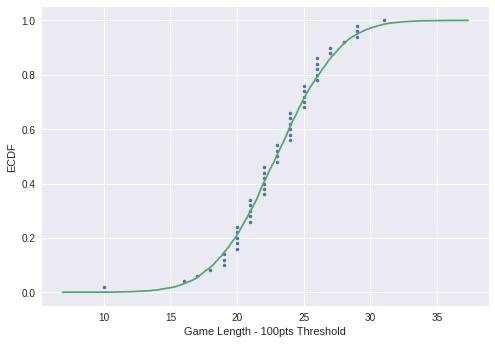

In [165]:
# Get ECDF for 100
x1,y1 = ecdf(df_gL[100])
# Plot the ECDF
_ = plt.plot(x1,y1, '.')
_ = plt.xlabel('Game Length - 100pts Threshold')
_ = plt.ylabel('ECDF')

# test if 100 is normally distributed.
# take random sampling and overlay ecdf
samples = np.random.normal(np.mean(df_gL[100]),np.std(df_gL[100]),size=10000)
x_theor,y_theor = ecdf(samples)
# Plot theoretical ECDF
_ = plt.plot(x_theor,y_theor)
plt.show()

Looks like a perfect fit, which is expected as we were simulating independent dices rolls from random.

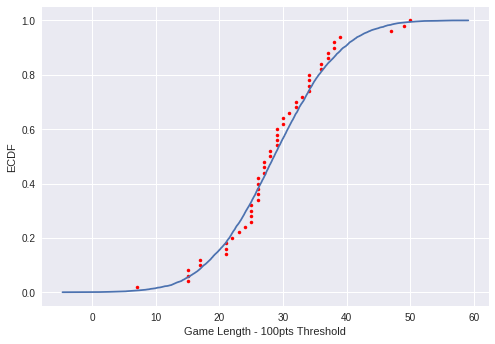

In [169]:
# Do the same for, say, 800

# Get ECDF for 100
x2,y2 = ecdf(df_gL[800])
# Plot the ECDF
_ = plt.plot(x2,y2, '.',c='red')
_ = plt.xlabel('Game Length - 100pts Threshold')
_ = plt.ylabel('ECDF')

# test if 100 is normally distributed.
# take random sampling and overlay ecdf
samples = np.random.normal(np.mean(df_gL[800]),np.std(df_gL[800]),size=10000)
x_theor2,y_theor2 = ecdf(samples)
# Plot theoretical ECDF
_ = plt.plot(x_theor2,y_theor2)
plt.show()

Different threshold, same distribution. 

Since the code is written up, I could just run 10000 simulations for each condition. But that takes a long time, and I want to practice some of the bootstrapping 'hacker statistics' skills I recently learned.

Specifically, I want to calculate the 95% confidence interval for the game length as a function of threshold using bootstrap sampling.


In [0]:
# I need two functions to be my work horses for this task

# a data sampler
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

# a generator
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    # Initialize array of replicates: bs_replicate as a place holder
    bs_replicates = np.empty(shape = size)
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates


In [207]:
# Apply to each threshold set and print
for i in df_gL:
  # Take 10,000 bootstrap replicates of the mean: bs_replicates
  bs_replicates = draw_bs_reps(df_gL[i].values, np.mean, size=10000)
  # for 2.5 and 97.5 percentils of bootstrapped replicates
  bs_prc = np.percentile(bs_replicates, [2.5, 97.5])
  print('Threshold: ',i,' points')
  print('Avg. game length: ',np.mean(bs_replicates),' turns')
  print('95% confidence interval =', bs_prc,' turns')

Threshold:  100  points
Avg. game length:  22.918376000000002  turns
95% confidence interval = [21.88 23.94]  turns
Threshold:  200  points
Avg. game length:  22.552994  turns
95% confidence interval = [21.26 23.9 ]  turns
Threshold:  300  points
Avg. game length:  23.168494  turns
95% confidence interval = [21.78 24.62]  turns
Threshold:  400  points
Avg. game length:  23.170358  turns
95% confidence interval = [21.76 24.6 ]  turns
Threshold:  500  points
Avg. game length:  22.817638  turns
95% confidence interval = [21.28 24.5 ]  turns
Threshold:  600  points
Avg. game length:  26.466644  turns
95% confidence interval = [24.52 28.48]  turns
Threshold:  700  points
Avg. game length:  26.17546  turns
95% confidence interval = [24.3  28.12]  turns
Threshold:  800  points
Avg. game length:  28.629174  turns
95% confidence interval = [26.32 31.02]  turns
Threshold:  900  points
Avg. game length:  30.630308000000003  turns
95% confidence interval = [28.4  32.84]  turns
Threshold:  1000  po

Based on the confidence intervals of 10000 bootstrapped samples, there does not appear to be a noticeable increase when going from 100-500pts, but going above 500 looks pretty risky.

We could also calculate the difference p-value to see if going from 500->600 is in fact significantly worse, but I don't think it is necessary. 

Based on these results, I hypothesize that never re-rolling is the optimal strategy. Take what you can get, because something is better than nothing. If you roll 1x 1 for 100s, and have the option of re-rolling, this data would suggest your best move to is take the 100 and end.

Next steps: 

To test the hypothesis, that re-rolling alone is more important than thresholding, I'll need to make some changes to the code. 

I would also like to try gamify this code, and use Deep Learning to see if there are any strategies I'm not considering. 